<a href="https://colab.research.google.com/github/decomiteA/ReachRLToolbox/blob/OFC_FF/OFC_2D_FF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**At the end of this tutorial you should be able to:**

* Write the equations that characterise the dynamics of a system in their matricial form.

* Express the cost function corresponding to a task as a sum of quadratic forms and understand the meaning of the different parameters of this cost function

* Implement the backward recursion that determines the optimal set of gains to be applied in order for the controller to behave optimally

* Apply a Kalman filter as an optimal observer of the system we want to model

## Import and helper functions
**Please execute the cell below to initialize the notebook environment**

In [1]:
#@title Imports
import numpy as np
import matplotlib.pyplot as plt

# Section 1 - State space representation

In this first section, we will model the system we are going to control. We will consider a 2-dimensional model of the upper limb dynamics. 

Let $\textbf{x}$ be the state vector that characterises the system. This state vector contains all the information we want to keep track about the system (position (x,y), velocity($\dot{x}$,$\dot{y}$), forces($F_x$,$F_y$),...) and external force field ($F^{ext}_x$,$F^{ext}_y$). 

We will start from basic dynamics equations :

\begin{eqnarray}
\sum_i \vec{F}_i = m\vec{a}_i
\end{eqnarray}

For upper limb movements, we obtain the following equations :  


\begin{eqnarray}
\ddot{x} & = & -k_v \dot{x} + F_x + F^{ext}_x\\
\ddot{y} & = & -k_v \dot{y} + F_y + F^{ext}_y\\
\tau \dot{F_x} & = & u_x - F_x\\
\tau \dot{F_y} & = & u_y - F_y\\
\end{eqnarray}



In order to be able to numerically handle these equations, we have to **discretize** these. Before this discretization step, we have to transform every second order differential equation in two first order differential equations using the following trick:


\begin{eqnarray}
u'' & = & a_0 u +a_1 u' \\
\begin{bmatrix}
u' \\ u''
\end{bmatrix}
 & = & \begin{bmatrix}
 0 & 1 \\ a_0 & a_1
 \end{bmatrix}
 \begin{bmatrix}
 u\\
 u'
 \end{bmatrix}
\end{eqnarray}


**Exercise 1A**

Rewrite the Newton's equations using the trick above in a matricial form 

\begin{equation}
\dot{x}(t) = Ax(t) + Bu(t) + noise(t)
\end{equation}

Find the A and the B matrices for this system (the noise will be handled later).

**Exercise 1B**

Discretize these equations using  Euler's method in order to obtain the following system:

\begin{eqnarray}
x[t+1] & = & A_{discrete} x[t] + B_{discrete}u[t] + noise[t]
\end{eqnarray}



**In the cell below**, enter the discretized version of your **A** & **B** matrices : 

In [8]:
N = 50  # Nb of steps

dt = 0.01
kv = 0.1
tau = 0.05
lamb = 0
ns = 8

###############################
## Complete the code below ####
###############################


A = np.array([[1,0,dt,0,0,0,0,0],[0,1,0,dt,0,0,0,0],[0,0,1-kv*dt,0,dt,0,dt,0],[0,0,0,1-kv*dt,0,dt,0,dt],[0,0,0,0,1-dt/tau,0,0,0],[0,0,0,0,0,1-dt/tau,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
B = np.zeros((8,2))
B[4,:]=np.array([dt/tau,0])
B[5,:]=np.array([0,dt/tau])

## Section 2 - Cost Function

In this second section, we have to define how we want to perform the movement. Two parameters have to be taken into account:

* The end-point accuracy (how close to the goal we want to end)
* The energitical expenditure we want to engage in the task

These two terms can be encapsulated using the following equation :
\begin{eqnarray}
J(\bar{x},\bar{u}) & = & \bar{x}_N^T Q_N \bar{x}_N + \sum_i \bar{u}_i^T R \bar{u}_i
\end{eqnarray}

For the end-point accuracy, we want to determine the $Q_N$ matrix such that : 
\begin{eqnarray}
\bar{x}_N^T Q_N \bar{x}_N & = & w_1 x_N^2 + w_2 y_N^2 + w_3 v_x^2 + w_4 v_y^2
\end{eqnarray}

**Exercise 2**

Using this inequality, determines the shape and entries of the matrix $Q_N$ and complete the code below. Choose arbitrary values for the $w_i$s, you would have time later on to investigate their impact.

In [17]:
###############################
## Complete the code below ####
###############################

w1 = 100
w2 = 100
w3 = 0.1
w4 = 0.1
QN = np.zeros((8,8))
QN[0,0]=w1
QN[1,1]=w2
QN[2,2]=w3
QN[3,3]=w4
# We set the R matrix as follows, later on you can change it to see its effect on the controller
R = np.array([(10 ** -4, 0), (0, 10 ** -4)])

## Section 3 - Optimal Control

Now that our system is defined and that we have our cost function, we want to find the control sequence $u_1$, $u_2$, $u_3$, ... $u_n$ that minimizes the cost. From all the motor commands we can do to reach our goal, we want to find the most optimal. 

The solution of this problem ([proof here]()) is given by the following **backward** recursion.

\begin{eqnarray}
S_N &=& Q_N, \qquad s_N = 0,\\
L_k &=& \left(R+B^TS_{k+1}B\right)^{-1}B^TS_{k+1}A,\\
S_k &=& Q_k + A^TS_{k+1}(A-BL_k).
\end{eqnarray}

We can simulate the system forward since the control signal is defined as $u_k = -L_k x_k$, the dynamics becomes:

\begin{eqnarray}
x_{k+1} = (A-BL_k)x_k + \xi_k.
\end{eqnarray}

Where $\xi_k \sim \mathcal{N}(0,\Omega_{\xi})$, which corresponds to the noise on the motor command. The covariance matrix, $\Omega_{\xi}$, has very low values ( $10^{-4}$).


**Exercise 3a** 

Implement the background recursion to compute the control gains of the controler


In [19]:
L = np.zeros((N, 2, ns))
S = np.zeros((N, ns, ns))
Q = np.zeros((N, ns, ns))

###############################
## Complete the code below ####
###############################
# (hint : fill in L and S matrices in the backward loop)
Q[N - 1, :, :] = QN
S[N - 1, :, :] = QN

for i in range(N - 1, 0, -1):
  L[i,:,:]=np.linalg.solve(R+B.T@S[i,:,:]@B,B.T@S[i,:,:]@A)
  S[i-1,:,:]=A.T@S[i,:,:]@(A-B@L[i,:,:])


Using the control gains you have computed above, you can already simulate some movements, try to set a goal and run your code to see if this model behaves as you would expect.

**Exercise 3b**

Simulate the movement using the control gains you just computed 

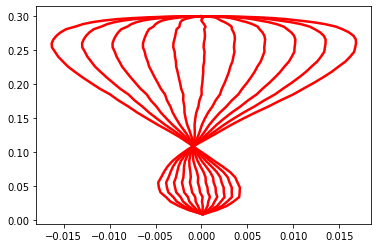

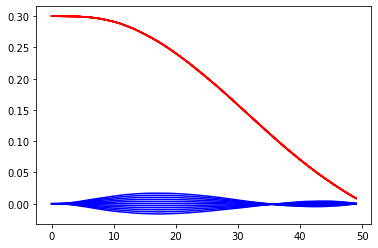

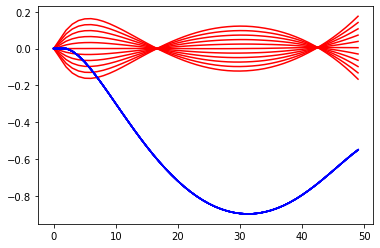

In [28]:
FF_values = np.arange(-5,6)
X = np.zeros((N, ns, len(FF_values)))
#Change the first entries of the vector below to investigate different starting position
for ii in range(len(FF_values)):
  X[0, :, ii] = [0,0.3,0,0,0,0,FF_values[ii],0]

#Computation of the motor noise 
Xi = np.random.normal(loc=0, scale=10 ** -4, size=(N, ns, 1))

###############################
## Complete the code below ####
###############################
for j in range(0, N - 1):
  X[j+1,:,:]=(A-B@L[j,:,:])@X[j,:,:]+Xi[j,:,:]

#Create a representation of positions and speeds with respect to time and characterise their evolution
fig, ax=plt.subplots()
ax.plot(X[:,0,:],X[:,1,:],'r',LineWidth=2.5)
fig, ax=plt.subplots()
ax.plot(range(N),X[:,0,:],'b')
ax.plot(range(N),X[:,1,:],'r')
fig, ax=plt.subplots()
ax.plot(range(N),X[:,2,:],'r')
ax.plot(range(N),X[:,3,:],'b')

##Section 4 - State Estimation

Despite the good movements simulated by our model, this does not match with the reality. Indeed, we don't have access to the exact state of our body. We have to estimate it by combining sensory feedback information (visual, somatosensory, ... ) with the dynamics we know of our body. For example, when we contract a muscle we know that our limb will move, and we know approximatly how it will move.

Due to the uncertainty we have on both informations, we will combine them in an optimal and continuous way by using the **Kalman filter** we saw in the previous tutorial.

We will consider that the information we extracted from our sensory feedback can be defined as follow : 
\begin{eqnarray*}
y_k = Hx_k + \omega_k,
\end{eqnarray*}
with $\omega_k \sim \mathcal{N}(0,\Omega_{\omega})$ which corresponds to the sensory noise, the covariance matrix in this case will have values around $10^{-2}$. 

The kalman gains that allows us to combine these informations can be computed using the following forward recursion: 
\begin{eqnarray}
\Sigma_1, \hat{x}_1&&  \textrm{given}\\
K_{k} &=& A\Sigma_kH^T\left(H\Sigma_KH^T+\Omega_{\omega}\right)^{-1},\\
\Sigma_{k+1} &=& \Omega_{\xi} + (A-K_kH)\Sigma_k A^T\\
\hat{x}_{k+1} &=& A\hat{x}_k + B u_k + K_{k}\left(y_k - H\hat{x}_k\right).
\end{eqnarray}

Where $\Sigma_1 = 10^{-6} \mathbb{I}_n$.


Compare the results you obtained when adding feedback to the results you obtained earlier.


**Warning** : Since the real state of the system is not correctly accessible, it cannot be used by the controller to generate the command. The motor system has therefore to use the best approximation it has about this state which is the current state estimation $\hat{x}$.


**Exercise 4** 

Add the Kalman filter to your controller to implement the optimal state estimator by completing the cell below.


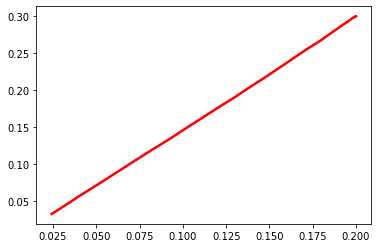

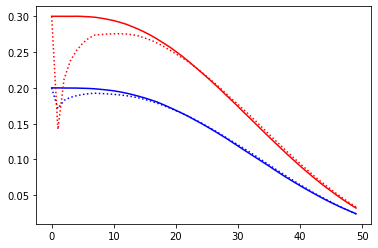

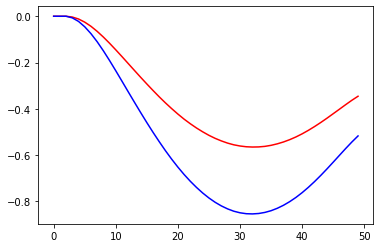

In [ ]:
#Initialize the state estimation... What is the size of hte matrix? How would you complete the information corresponding to the first time step? 

Xhat = np.zeros_like(X)
Xhat[0, :, :] = X[0,:,:] + np.random.normal(loc=0, scale=10 ** -6, size=(6, 1))

#Initialization of the command and observable
Y = np.zeros((N, ns, 1))
U = np.zeros((N,2,1))


#Initialization of the covariance matrix of the state, how would you initialize the first covariance matrix? 
Sigma = np.zeros((N, ns, ns))
Sigma[0,:,:] = np.random.normal(loc=0, scale=10 ** -2, size=(1, ns, 1))


#Some more initialization (nothing to do for you here)
K = np.zeros((N, ns, ns))
H = np.eye(ns)
Xi = np.random.normal(loc=0, scale=10 ** -4, size=(N, ns, 1))
Omega = np.random.normal(loc=0, scale=10 ** -2, size=(N, ns, 1))
oXi = 0.1 * (B @ B.T)
oOmega = 0.1 * np.max(np.max(oXi)) * np.eye(ns)

#Fill in the following loop to complete 
# 
# state evolution
# observatoin evolutino
# computation of K and Sigma
# computation of the command
# evolution of the state estimation

for j in range(0, N - 1):
  X[j+1,:,:]=A@X[j,:,:]-B@L[j,:,:]@Xhat[j,:,:]+Xi[j,:,:]
  Y[j+1,:,:] = H@X[j,:,:]+Omega[j+1,:,:]

  K[j,:,:] = A@Sigma[j,:,:]@H.T@np.linalg.inv(H@Sigma[j,:,:]@H.T+oOmega)
  Sigma[j+1,:,:] = oXi + (A-K[j,:,:]@H)@Sigma[j,:,:]@A.T

  Xhat[j+1,:,:] = (A-B@L[j,:,:])@Xhat[j,:,:] + K[j,:,:]@(Y[j,:,:]-H@Xhat[j,:,:])

#Plot the time evolution of the state, its observation and its estimation.. What do you observe? 
fig, ax=plt.subplots()
ax.plot(X[:,0,:],X[:,1,:],'r',LineWidth=2.5)
fig, ax=plt.subplots()
ax.plot(range(N),X[:,0,:],'b')
ax.plot(range(N),X[:,1,:],'r')
ax.plot(range(N),Xhat[:,0,:],'b:')
ax.plot(range(N),Xhat[:,1,:],'r:')
fig, ax=plt.subplots()
ax.plot(range(N),X[:,2,:],'r')
ax.plot(range(N),X[:,3,:],'b')